In [2]:
import os, sys
import glob
import json
import re

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.colors as clr

from scipy.stats import ttest_ind, f_oneway
from scipy.stats import chisquare, fisher_exact, power_divergence


sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
import analysis_utils as utils

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-12-08 09:36:58.779680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 09:36:58.779745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 09:36:58.779780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 09:36:58.789578: I tensorflow/core/platform/cpu_feature_guard.cc

In [182]:
# Sourced for aggregating data across subjects
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')
behavioral_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/') # where we will write our data

## Define function for extracting phonemes

In [211]:
import nltk
from functools import lru_cache
from itertools import product as iterprod

try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

## Load subject-level results

In [186]:
# Load results
df_results = pd.read_csv(os.path.join(behavioral_dir, f'all-task_subject-behavior_lemmatized.csv'))

# Create dataframe for evaluating leakage
df_leakage = pd.DataFrame(columns=[
        'task', 'modality', 'word_index', 
        'wrong_resp_correct', 'wrong_resp_incorrect', 'wrong_resp_accuracy', # focusing on the wrong responses, how many were correct v. incorrect
        
])

for (task, modality, word_index), df in df_results.groupby(['task', 'modality', 'word_index']):

    ground_truth = df['ground_truth'].unique()[0]
    ground_truth_phoneme = wordbreak(ground_truth)[0][0]

    responses = df['response'].to_numpy()

    # Get first letter of each response
    predicted_phoneme = [wordbreak(word)[0][0] for word in responses]
    unique, counts = np.unique(predicted_phoneme, return_counts=True)

    # Find accuracy of first letter
    phoneme_accuracy = np.asarray([phone == ground_truth_phoneme for phone in predicted_phoneme])

    # Focus on wrong responses
    wrong_responses = np.argwhere(responses != ground_truth)

    if len(wrong_responses) >= 1:
        wrong_phonemes = np.asarray(predicted_phoneme)[wrong_responses]
        wrong_accuracy = phoneme_accuracy[wrong_responses]

        # Get number of correct responses for the wrong response
        wrong_resp_correct = np.sum(wrong_accuracy)
        wrong_resp_incorrect = len(wrong_accuracy) - wrong_resp_correct
        wrong_resp_accuracy = wrong_resp_correct / len(wrong_accuracy)
    else:
        wrong_resp_correct = np.nan 
        wrong_resp_incorrect = np.nan 
        wrong_resp_accuracy = np.nan

    df_leakage.loc[len(df_leakage)] = {
        'task': task,
        'modality': modality,
        'word_index': word_index,
        'wrong_resp_correct': wrong_resp_correct,
        'wrong_resp_incorrect': wrong_resp_incorrect,
        'wrong_resp_accuracy': wrong_resp_accuracy,
    }

## Calculate leakage statistics

For each predicted word, create a contingency table of (audio v. text) x (correct v. incorrect) specifically for the wrong responses.

In [208]:
all_pvals = []
df_pvals = pd.DataFrame(columns=['task', 'word_index', 'pval'])

for (task, word_index), df in df_leakage.groupby(['task', 'word_index']):

    contingency = df[['wrong_resp_correct', 'wrong_resp_incorrect']].to_numpy().astype(float)

    if np.isnan(contingency).any():
        continue
    stat, pval = fisher_exact(contingency, alternative='two-sided')

    df_pvals.loc[len(df_pvals)] = {
        'task': task,
        'word_index': word_index,
        'pval': pval
    }

### Plot phoneme accuracy across tasks

Text(0.5, 1.05, 'Phoneme accuracy across tasks')

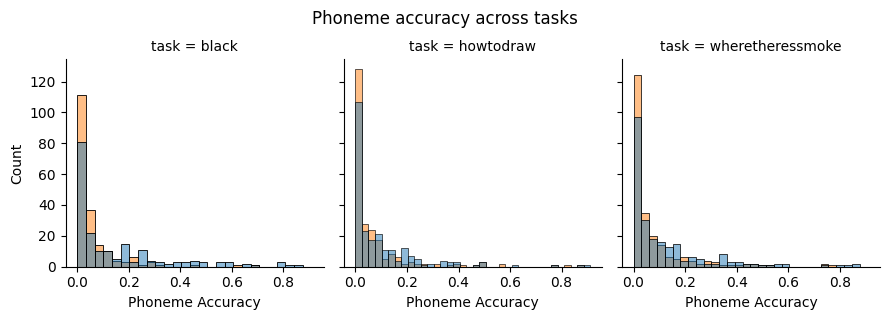

In [209]:
g = sns.FacetGrid(df_leakage, col="task")
g.map_dataframe(sns.histplot, x="wrong_resp_accuracy", hue='modality')

g.set_axis_labels("Phoneme Accuracy", "Count")
plt.suptitle('Phoneme accuracy across tasks', y=1.05)

### Calculate percentage of words with significant leakage

In [214]:
print (f'Percent significant leakage\n')

percent_leakage = []

for i, df in df_pvals.groupby('task'):
    perc = 100 * (sum(df['pval'] < 0.05) / len(df))
    print (f'Task: {i} -- {perc:.2f}%')
    percent_leakage.append(perc)

Percent significant leakage

Task: black -- 21.76%
Task: howtodraw -- 7.14%
Task: wheretheressmoke -- 13.19%


### Plot distribution of leakage p-values

Text(0.5, 1.05, 'Fisher Exact - Pvals')

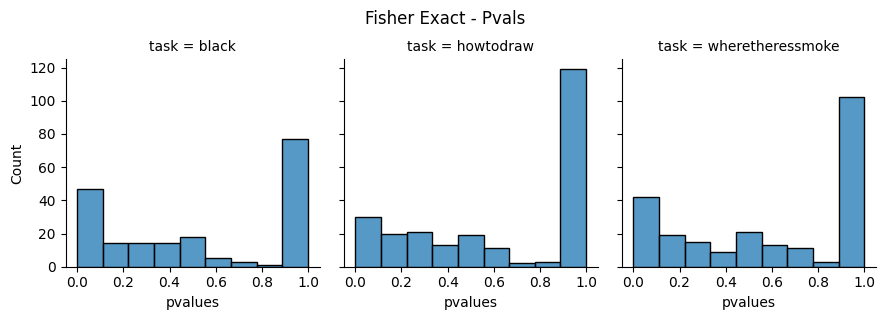

In [181]:
g = sns.FacetGrid(df_pvals, col="task")
g.map_dataframe(sns.histplot, x="pval")

g.set_axis_labels("pvalues", "Count")
plt.suptitle('Fisher Exact - Pvals', y=1.05)